In [6]:
import pandas as pd

merged = pd.read_csv("../2_data/sentiment_price_vix_inner_aligned.csv", parse_dates=["created_at"])

# check col
print(merged.columns)
print(merged[["created_at", "daily_finbert"]].head())

Index(['created_at', 'daily_finbert', 'nvda_close', 'nvda_return',
       'vix_close'],
      dtype='object')
  created_at  daily_finbert
0 2013-04-11       0.105690
1 2013-04-12       0.208949
2 2013-04-15      -0.107966
3 2013-04-16      -0.000069
4 2013-04-17       0.281768


In [3]:
# threshold
mu = merged["daily_finbert"].mean()
sigma = merged["daily_finbert"].std()

upper = mu + 0.5*sigma     # sentiment score is higher than threshold -> buy
lower = mu - 0.5*sigma     # sentiment score is lower than threshold -> sold


print(f"avg: {mu:.4f}, sd: {sigma:.4f}")
print(f"Buy if > {upper:.4f}, Sell if < {lower:.4f}")

# transaction signal
def generate_signal(score):
    if score > upper:
        return 1    # Buy
    elif score < lower:
        return -1   # Sell
    else:
        return 0    # Hold

merged["signal"] = merged["daily_finbert"].apply(generate_signal)

print(merged[["created_at", "daily_finbert", "signal"]].head(10))

merged.to_csv("sentiment_signal_full.csv", index=False)


avg: 0.1226, sd: 0.0426
Buy if > 0.1439, Sell if < 0.1013
  created_at  daily_finbert  signal
0 2013-04-11        0.10569       0
1 2013-04-11        0.10569       0
2 2013-04-11        0.10569       0
3 2013-04-11        0.10569       0
4 2013-04-11        0.10569       0
5 2013-04-11        0.10569       0
6 2013-04-11        0.10569       0
7 2013-04-11        0.10569       0
8 2013-04-11        0.10569       0
9 2013-04-11        0.10569       0


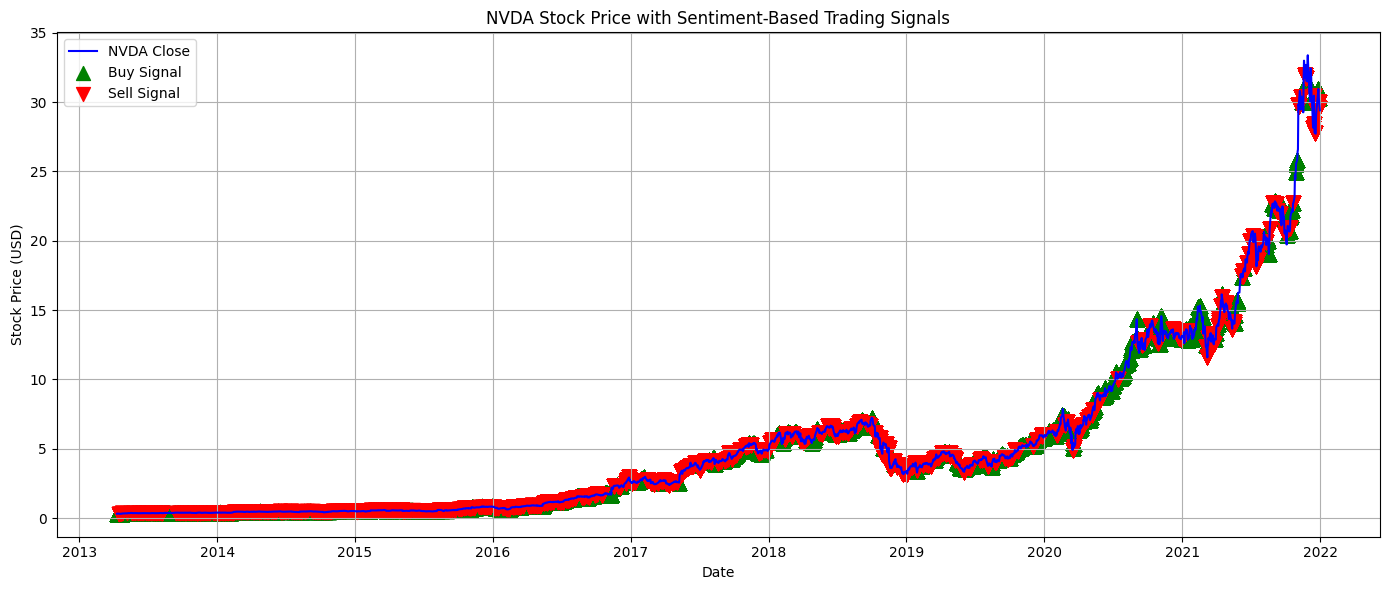

In [4]:
import matplotlib.pyplot as plt

# select buy/sell col
buy_signals = merged[merged["signal"] == 1]
sell_signals = merged[merged["signal"] == -1]

plt.figure(figsize=(14, 6))

# NVDA price movement
plt.plot(merged["created_at"], merged["nvda_close"], label="NVDA Close", color="blue")

# buy signal (green tri)
plt.scatter(buy_signals["created_at"], buy_signals["nvda_close"], 
            marker="^", color="green", label="Buy Signal", s=100)

# sell signal (red tri)
plt.scatter(sell_signals["created_at"], sell_signals["nvda_close"], 
            marker="v", color="red", label="Sell Signal", s=100)

plt.title("NVDA Stock Price with Sentiment-Based Trading Signals")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
  print(df['trade_signal'].value_counts())
  print(df['signal'].value_counts())

  print(df['nvda_return'].describe())

  print(df[['created_at', 'nvda_return', 'trade_signal']].dropna().head())
  print(df.shape)

trade_signal
 0.0    199190
-1.0    141297
 1.0    114256
Name: count, dtype: int64
signal
 0    199190
-1    141297
 1    114256
Name: count, dtype: int64
count    454743.000000
mean          0.002677
std           0.045127
min          -0.187559
25%          -0.018703
50%           0.002622
75%           0.022337
max           0.298067
Name: nvda_return, dtype: float64
  created_at  nvda_return  trade_signal
0 2013-04-11    -0.004677           0.0
1 2013-04-11    -0.004677           0.0
2 2013-04-11    -0.004677           0.0
3 2013-04-11    -0.004677           0.0
4 2013-04-11    -0.004677           0.0
(454743, 11)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/axes/_base.py:3054: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


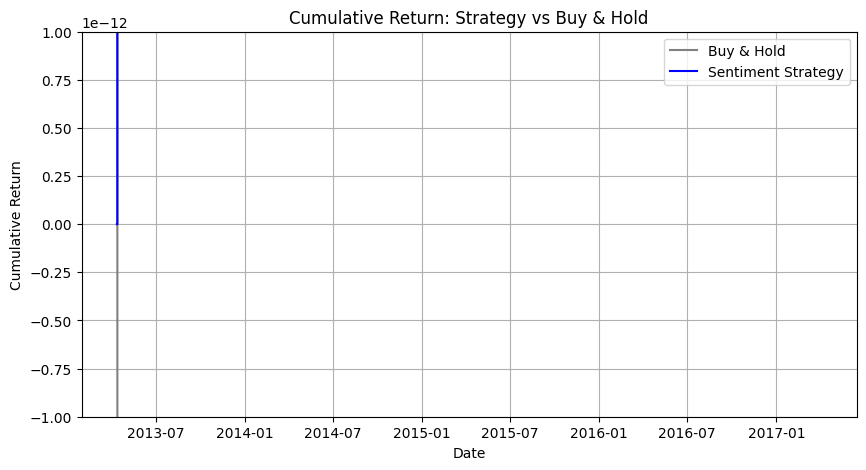

In [5]:
import numpy as np

df = merged.copy()

# move signal to +1 day
df["trade_signal"] = df["signal"].shift(1).fillna(0)

# strategy return：hold signal=1 then nvda_return，otherwise 0
df["strategy_return"] = df["trade_signal"] * df["nvda_return"]

# return
df["cum_strategy"] = (1 + df["strategy_return"]).cumprod() - 1
df["cum_bnh"]      = (1 + df["nvda_return"]).cumprod() - 1

# viz
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["created_at"], df["cum_bnh"], label="Buy & Hold", color="gray")
plt.plot(df["created_at"], df["cum_strategy"], label="Sentiment Strategy", color="blue")
plt.title("Cumulative Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

## Low Threshold
- The low threshold method better fits the current data’s neutral sentiment distribution, improving the strategy’s performance.


In [4]:
# Low Threshold
low_threshold = 0.05  

print(f"Buy if daily_finbert > {low_threshold:.4f}, Sell if < {-low_threshold:.4f}")

# signal generation
def generate_signal_lowth(score):
    if score > low_threshold:
        return 1    # Buy
    elif score < -low_threshold:
        return -1   # Sell
    else:
        return 0    # Hold

merged["signal"] = merged["daily_finbert"].apply(generate_signal_lowth)

print(merged[["created_at", "daily_finbert", "signal"]].head(10))

#save
merged.to_csv("sentiment_signal_full_lowth.csv", index=False)

Buy if daily_finbert > 0.0500, Sell if < -0.0500
  created_at  daily_finbert  signal
0 2013-04-11       0.105690       1
1 2013-04-12       0.208949       1
2 2013-04-15      -0.107966      -1
3 2013-04-16      -0.000069       0
4 2013-04-17       0.281768       1
5 2013-04-18       0.135414       1
6 2013-04-19       0.142858       1
7 2013-04-22      -0.000016       0
8 2013-04-23       0.408786       1
9 2013-04-24       0.166727       1


- Visualization: signal + stock price

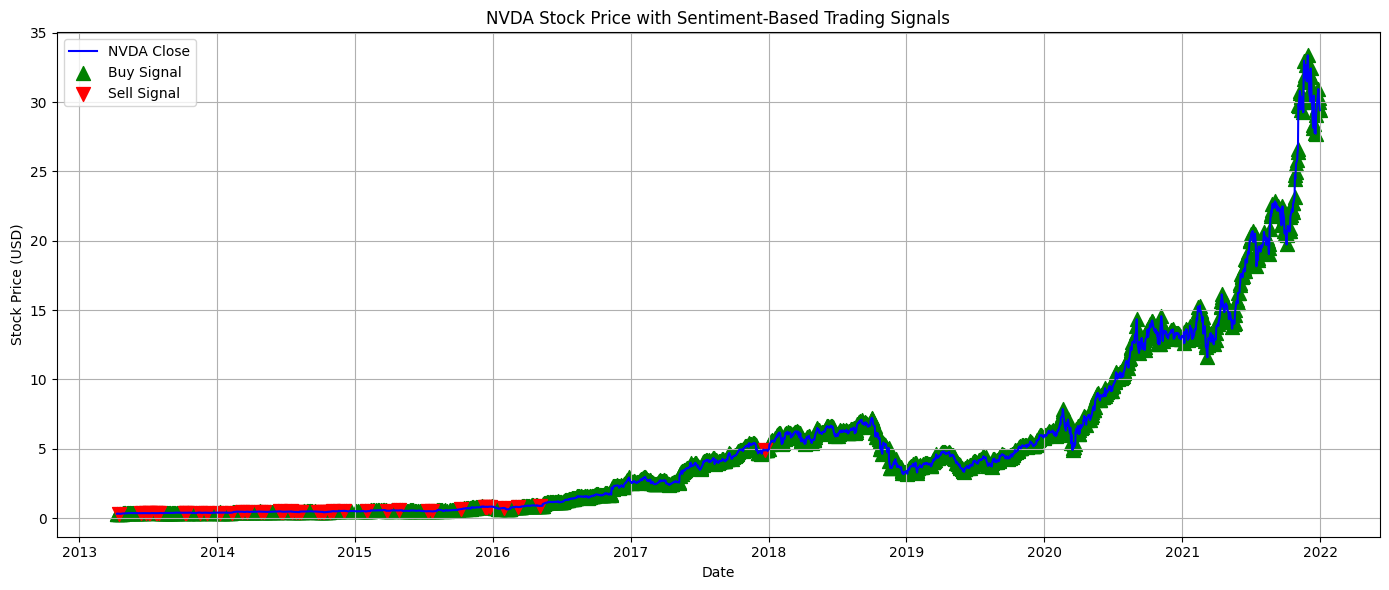

In [5]:
import matplotlib.pyplot as plt

# select buy/sell col
buy_signals = merged[merged["signal"] == 1]
sell_signals = merged[merged["signal"] == -1]

plt.figure(figsize=(14, 6))

# NVDA price movement
plt.plot(merged["created_at"], merged["nvda_close"], label="NVDA Close", color="blue")

# buy signal (green tri)
plt.scatter(buy_signals["created_at"], buy_signals["nvda_close"], 
            marker="^", color="green", label="Buy Signal", s=100)

# sell signal (red tri)
plt.scatter(sell_signals["created_at"], sell_signals["nvda_close"], 
            marker="v", color="red", label="Sell Signal", s=100)

plt.title("NVDA Stock Price with Sentiment-Based Trading Signals")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

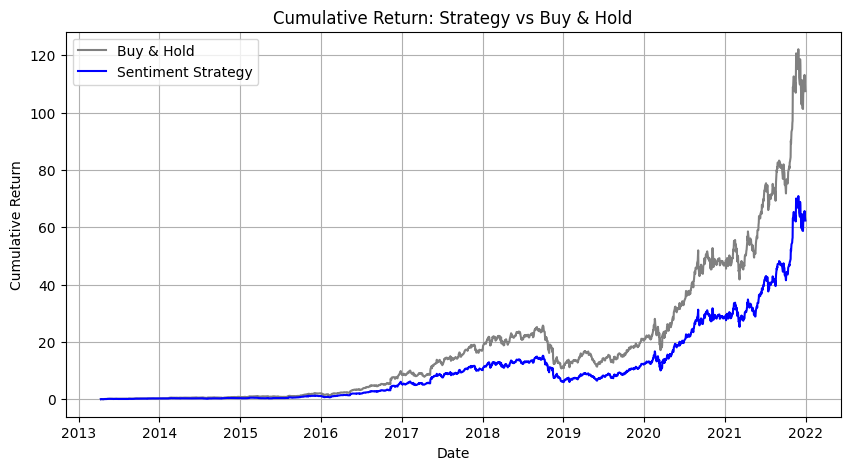

In [7]:
import numpy as np

df = merged.copy()

# move signal to +1 day
df["trade_signal"] = df["signal"].shift(1).fillna(0)

# strategy return：hold signal=1 then nvda_return，otherwise 0
df["strategy_return"] = df["trade_signal"] * df["nvda_return"]

# return
df["cum_strategy"] = (1 + df["strategy_return"]).cumprod() - 1
df["cum_bnh"]      = (1 + df["nvda_return"]).cumprod() - 1

# viz
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["created_at"], df["cum_bnh"], label="Buy & Hold", color="gray")
plt.plot(df["created_at"], df["cum_strategy"], label="Sentiment Strategy", color="blue")
plt.title("Cumulative Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

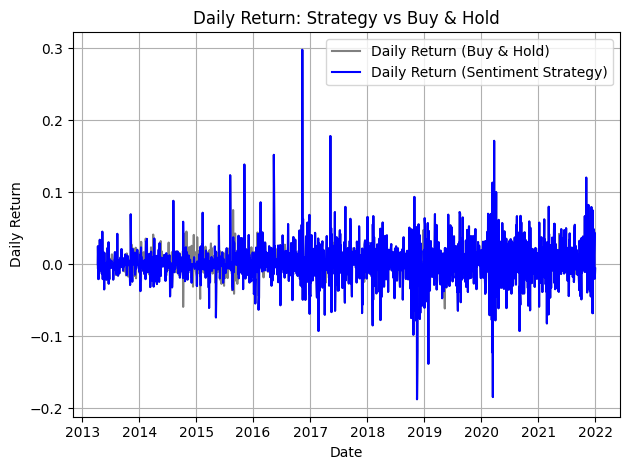

In [8]:
plt.plot(df["created_at"], df["nvda_return"], label="Daily Return (Buy & Hold)", color="gray")

plt.plot(df["created_at"], df["strategy_return"], label="Daily Return (Sentiment Strategy)", color="blue")

plt.title("Daily Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()